# RNN_driven_strategy

__Description__

...

__Journal of negative results__

...

In [2]:
# imports
%run ../modules/pnl_module.ipynb
%run ../modules/objectives_module.ipynb
%run ../modules/tools_module.ipynb

In [3]:
import pandas as pd
import datetime
import numpy.ma as ma
import tqdm
import glob

### Data prepare

In [84]:
sectors_data = pd.read_csv('../data/spx_dataset/gics_sectors.csv', usecols=['ISIN', 'sector'], index_col='ISIN')

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [42]:
all_sectors = set(sectors_data.sector)
' '.join(map(str, all_sectors))

'nan Technology BasicMaterials Financial Diversified Energy Industrial Consumer Communications Utilities'

In [43]:
# params
#sectors_need = ['Financial', 'Technology', 'Industrial', 'Consumer', 'Communications']
sectors_need = ['Consumer']

FAST_PERIOD = 26
SLOW_PERIOD = 46
FUTRET_WINDOW = 50
START_DATE = datetime.datetime(2006, 1, 1)

In [44]:
sector_subset = [sym for sym in sectors_data.index if sectors_data['sector'].loc[sym] in sectors_need] 

In [45]:
data_path = '../data/spx_dataset/{}.csv'
args = {'parse_dates' : ['Date'], 'index_col' : 'Date', 'usecols' : (['Date'] + sector_subset)}
tickers = pd.read_csv(data_path.format('un_spx_daily_nonadjusted_close'), **args).columns

In [46]:
un_returns, un_a_pct_returns, un_na_price, in_spx_mask, un_a_price, si_factor, ra_factor, frac_factor, div_yields =\
        map(lambda filename:\
        read_data(filename, args, start_idx=START_DATE),\
        map(lambda s: data_path.format(s), ['un_spx_adjusted_returns', 'un_spx_adjusted_pct_returns', \
                                            'un_spx_daily_nonadjusted_close', 'in_spx_mask',\
                                            'un_spx_daily_adjusted_close',\
         'Features/SI_FACTOR', 'Features/RA_FACTOR', 'Features/FRAC_FACTOR', 'Features/un_spx_div_yields']))

print('Shapes: {}, {}, {}, {}, {}, {}, {}, {}'.format(un_returns.shape, un_na_price.shape, un_a_price.shape,\
                in_spx_mask.shape, ra_factor.shape, si_factor.shape, frac_factor.shape, div_yields.shape))

Shapes: (2835, 253), (2835, 253), (2835, 253), (2835, 253), (2835, 253), (2835, 253), (2835, 253), (2835, 253)


In [47]:
div_yields[np.isnan(div_yields)] = 0.

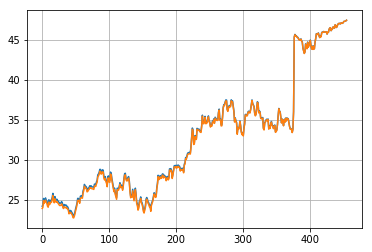

In [48]:
plt.figure()
plt.grid()
idx = np.random.randint(0, un_na_price.shape[1])
plt.plot(un_na_price[:, idx])
plt.plot(un_a_price[:, idx])

In [49]:
spy_pct_returns = read_data(data_path.format('spy_adjusted_percent_returns'), {'parse_dates' : ['Date'], 'index_col' : 'Date'}, START_DATE)
print('Shape: {}'.format(spy_pct_returns.shape))

Shape: (2835, 1)


In [50]:

recs_files = glob.glob('../data/spx_dataset/Features/RA_recs/*.csv')
recs_labels = list(map(lambda s: s[37:-4], recs_files))
recs_features = {}
for lab, filename in zip(recs_labels, recs_files):
    recs_features[lab] = read_data(filename, args, start_idx=START_DATE)


In [51]:
mask = (np.isfinite(frac_factor) * \
        np.isfinite(si_factor) * np.isfinite(ra_factor) *\
        (in_spx_mask==1) * np.isfinite(un_na_price)).astype('bool')

anti_mask = (1-mask).astype('bool')

In [52]:
un_na_price[np.isnan(un_na_price)]=10**6
un_returns[np.isnan(un_returns)]=0

# fill factors with nan under mask
ra_factor[anti_mask]=np.nan
si_factor[anti_mask]=np.nan
div_yields[anti_mask] = np.nan
frac_factor[anti_mask] = np.nan

In [53]:
"""
for lab in recs_labels:
    recs_features[lab][anti_mask] = np.nan
"""

'\nfor lab in recs_labels:\n    recs_features[lab][anti_mask] = np.nan\n'

In [54]:
"""
rec_labels_dict = pd.read_csv('../data/spx_dataset/Features/recs_labels_dict.csv', sep=';')
buy_labels = [lab.strip() for lab in list(rec_labels_dict['BUY'].dropna())]
sell_labels = [lab.strip() for lab in list(rec_labels_dict['SELL'].dropna())]
neutral_labels = [lab.strip() for lab in recs_labels if lab not in buy_labels and lab not in sell_labels]
"""

"\nrec_labels_dict = pd.read_csv('../data/spx_dataset/Features/recs_labels_dict.csv', sep=';')\nbuy_labels = [lab.strip() for lab in list(rec_labels_dict['BUY'].dropna())]\nsell_labels = [lab.strip() for lab in list(rec_labels_dict['SELL'].dropna())]\nneutral_labels = [lab.strip() for lab in recs_labels if lab not in buy_labels and lab not in sell_labels]\n"

In [55]:
"""
buy_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in buy_labels], axis=-1), axis=-1)
sell_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in sell_labels], axis=-1), axis=-1)
neutral_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in neutral_labels], axis=-1), axis=-1)
"""

'\nbuy_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in buy_labels], axis=-1), axis=-1)\nsell_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in sell_labels], axis=-1), axis=-1)\nneutral_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in neutral_labels], axis=-1), axis=-1)\n'

In [56]:
"""
buy_rec_factor[anti_mask] = np.nan
sell_rec_factor[anti_mask] = np.nan
neutral_rec_factor[anti_mask] = np.nan
"""

'\nbuy_rec_factor[anti_mask] = np.nan\nsell_rec_factor[anti_mask] = np.nan\nneutral_rec_factor[anti_mask] = np.nan\n'

In [57]:
#div_yields, frac_factor = map(relative_scaler, (div_yields, frac_factor))

In [58]:
features_tensor = np.stack([ra_factor, si_factor, div_yields, frac_factor], axis=-1)
#features_tensor2 = np.stack([buy_rec_factor, sell_rec_factor, neutral_rec_factor], axis=-1)
#features_tensor2 /= (np.nansum(features_tensor, axis=-1, keepdims=True))
#features_tensor = np.concatenate([features_tensor, sectors_factor], axis=-1)
#features_tensor = np.concatenate([features_tensor, features_tensor2[:, :, :-1]], axis=-1)

In [59]:
features_tensor = np.stack([ra_factor, si_factor, div_yields, frac_factor], axis=-1)
print(features_tensor.shape)
#features_tensor = np.concatenate([features_tensor, sectors_factor], axis=-1)

(2835, 253, 4)


In [60]:
print(features_tensor.shape)

(2835, 253, 4)


In [61]:
target = weighted_futret(un_a_pct_returns, FUTRET_WINDOW)
target[anti_mask]=np.nan

In [62]:
top_bottom_size = 20
print('Sector {}: {}'.format(sectors_need[0], top_bottom_size))

Sector Consumer: 20


In [63]:
np.log(target.shape[1]) 

5.5333894887275203

In [64]:
### Model (ranking)

In [65]:
OFFSET = FUTRET_WINDOW
WINDOW_TRAIN = 1000
RETRAIN_FREQ = 25
SAMPLING_SIZE = 20

In [66]:
features_tensor.shape, target.shape

((2835, 253, 4), (2835, 253))

In [67]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier

In [68]:
def get_ranker(t, transformer=None):
    X, y = dinamic_train_cut(features_tensor, target, t, WINDOW_TRAIN, OFFSET)
    X_train, y_train = ranker_unpack(X, y, SAMPLING_SIZE)
    #print(X_train)
    if transformer:
        X_train = transformer.fit_transform(X_train)
    #mod = SVC(max_iter = 1000).fit(X_train, y_train)
    mod = LogisticRegression(C=1., penalty='l2').fit(X_train, y_train)
    return mod.decision_function, transformer.transform

In [69]:


Q = np.empty(ra_factor.shape)
Q[:] = np.nan
start_t = OFFSET + WINDOW_TRAIN - 1
decision_fun, transform = get_ranker(start_t, PolynomialFeatures(1, False, False))
#decision_fun, transform = get_ranker(start_t, PolynomialFeatures(2))
for i in tqdm.tqdm(range(start_t, Q.shape[0])):
    if i % RETRAIN_FREQ == 0:
        decision_fun, transform = get_ranker(i, PolynomialFeatures(1, False, False))
        #decision_fun, transform = get_ranker(i, PolynomialFeatures(2))
    new_x = features_tensor[i, :, :]
    finite_idxs = np.where(np.isfinite(new_x).all(axis=1))[0]
    try:
        Q[i, finite_idxs] = decision_fun(transform(features_tensor[i, finite_idxs, :]) )  
    except:
        continue
        


100%|█████████████████████████████████████| 1786/1786 [00:16<00:00, 108.32it/s]


In [70]:
Q = np.where(np.isnan(Q), ma.array(Q, mask=np.isnan(Q)).mean(axis=1, keepdims=True), Q)  
#Q = np.where(np.isnan(ra_factor), ma.array(ra_factor, mask=np.isnan(ra_factor)).mean(axis=1, keepdims=True), ra_factor)  

In [71]:
### Backtest (ranking approach)

In [72]:
un_na_price, un_returns, mask, anti_mask = map(lambda df: df[start_t:,:], (un_na_price, un_returns, mask, anti_mask))
Q = Q[start_t:, :]

In [73]:
Q.shape, un_na_price.shape, mask.shape

((1786, 253), (1786, 253), (1786, 253))

In [74]:
_buying_power.set_value(10. ** 6)
_commis_per_share.set_value(0.01)
_nb_top.set_value(7)
_nb_bottom.set_value(7)

In [75]:
#shares = np.maximum(quality_to_share_robust_fun(Q, un_na_price, mask), 0)
shares = quality_to_share_robust_fun(Q, un_na_price, mask)
#shares = quality_to_share_soft_fun(Q, un_na_price, mask)
#shares = shares_norebalance(shares)

In [76]:
long_pos_count = (shares > 0).astype('float32').sum(axis=1)
short_pos_count = (shares < 0).astype('float32').sum(axis=1)
long_check = np.logical_or(long_pos_count == 0, long_pos_count == _nb_top.get_value()).all()
short_check = np.logical_or(short_pos_count == 0, short_pos_count == _nb_bottom.get_value()).all()
print('Robust matrix check pass: {}, {}'.format(long_check, short_check))

Robust matrix check pass: True, True


In [77]:
Q_ = Q
Q_[anti_mask] = np.nan

C:\Users\evgeniy.tumanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


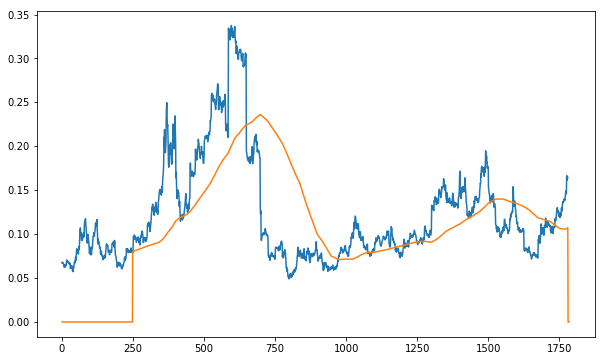

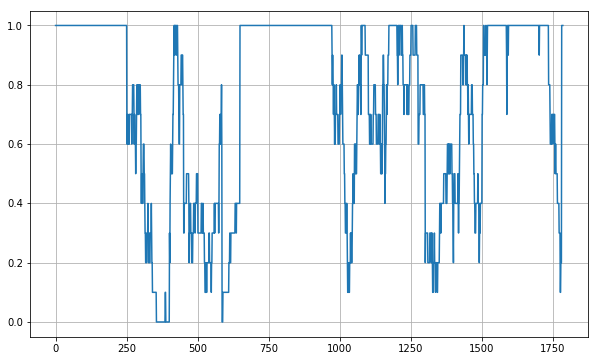

In [78]:


plt.figure(figsize=(10,6))
qual_range = np.nanstd(Q_, axis=1)
qual_rolling_mean = np.nan_to_num(numpy_matrix_sma(qual_range.reshape(-1, 1), 250)).ravel()
plt.plot(qual_range)
plt.plot(qual_rolling_mean)
conf = ((qual_range - qual_rolling_mean) / qual_rolling_mean)
conf[np.isinf(conf)] = 0
conf[np.isnan(conf)] = 0
conf = np.maximum(np.minimum(1-conf, 1), 0)
conf = np.floor( (conf ** 2) *10) / 10.

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(conf)


In [79]:
shares2 = shares * conf.reshape(-1, 1)

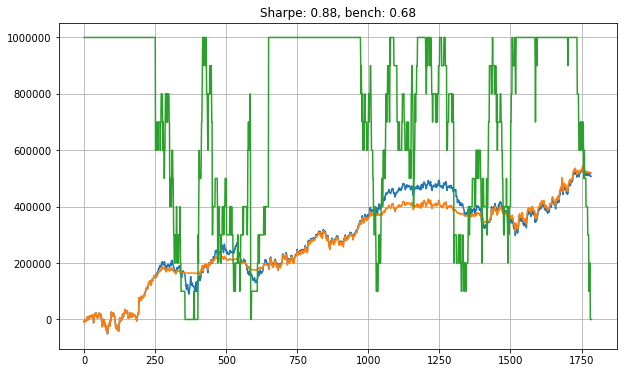

In [80]:
strategy_returns_arr = strategy_returns_fun(shares, un_returns)
strategy_returns_arr2 = strategy_returns_fun(shares2, un_returns)
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(strategy_returns_arr.cumsum())
plt.plot(strategy_returns_arr2.cumsum())

mval = market_value_fun(shares, un_na_price)
mval2 = market_value_fun(shares2, un_na_price)

#plt.plot(1000000 * qual_range)

#plt.plot(mval)
plt.plot(mval2)
plt.title('Sharpe: {}, bench: {}'.format(round(sharpe(strategy_returns_arr2), 2),\
                                        round(sharpe(strategy_returns_arr), 2)))

In [81]:
try:
    len(by_sector_ranking)
except NameError:
    by_sector_ranking = {}

In [82]:
by_sector_ranking[sectors_need[0]] = strategy_returns_arr

"\nsum_pl = 0.33 * (by_sector_ranking['Communications'] + by_sector_ranking['Industrial'] + by_sector_ranking['Consumer'])\nplt.plot(sum_pl.cumsum()[0:], linewidth=2)\n\nplt.title('Sharpe: {}'.format(round(sharpe(sum_pl), 2)))\n"

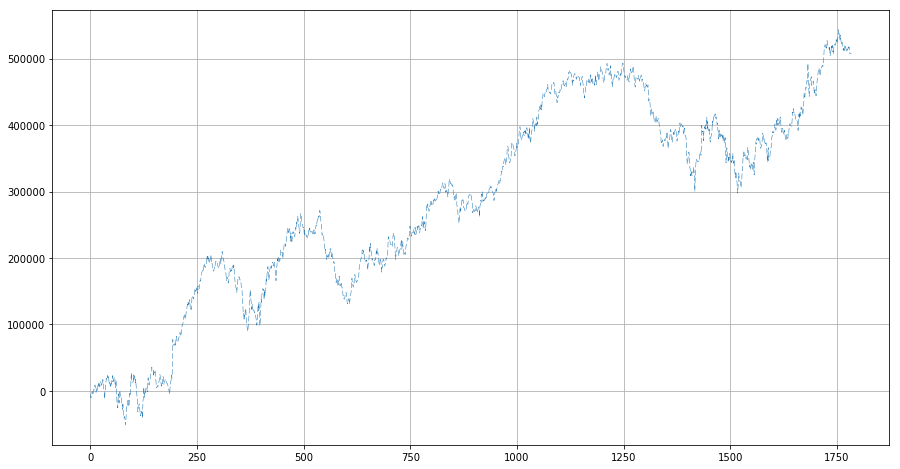

In [83]:

plt.figure(figsize=(15, 8))
plt.grid()

for k, v in list(by_sector_ranking.items()):
    plt.plot(v.cumsum()[0:], '--', linewidth=0.5)
  
"""
sum_pl = 0.33 * (by_sector_ranking['Communications'] + by_sector_ranking['Industrial'] + by_sector_ranking['Consumer'])
plt.plot(sum_pl.cumsum()[0:], linewidth=2)

plt.title('Sharpe: {}'.format(round(sharpe(sum_pl), 2)))
"""